<a href="https://colab.research.google.com/github/ilia-kuznetsov-hds/machine_learning_project/blob/main/2025_10_ML_II_Week_02_Deep_Computer_Vision_Using_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Computer Vision Using Convolutional Neural Networks

Sources:
* [Chapter 12](https://learning.oreilly.com/library/view/hands-on-machine-learning/9798341607972/ch12.html#id563) of Hands-On Machine Learning with Scikit-Learn and PyTorch By Aurélien Géron.  
* [CNN Explainer](https://poloclub.github.io/cnn-explainer/)





In [36]:
# we are working in Colab
%pip install -q torchmetrics

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F # for the manual convolution operation
import torchmetrics
import numpy as np
from sklearn.datasets import load_sample_images

import matplotlib.pyplot as plt
# setting from the textbook
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import torchvision
import torchvision.transforms.v2 as T

torch.manual_seed(42)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps" # for Apple
else:
    device = "cpu"

torch.manual_seed(42)


# Implementing Convolutional Layers with PyTorch

## Basic transformation of image to tensor

The first image represents the tower of buddhist incense in China, while the second one represents a beautiful Dahlia pinnata flower. These images are represented as a Python list of NumPy unsigned byte arrays, so let’s stack these images into a single NumPy array, then convert it to a 32-bit float tensor, and rescale the pixel values from 0–255 to 0–1:

In [38]:
# load two sample images and convert them to a float tensor
sample_images = np.stack(load_sample_images()["images"])

# converts the NumPy array to a PyTorch tensor of floats.
# Dividing by 255 rescales pixel values from [0, 255] → [0.0, 1.0] (a standard normalization step).
sample_images = torch.tensor(sample_images, dtype=torch.float32) / 255

* **np.stack** - Join a sequence of arrays along a new axis. The axis parameter specifies the index of the new axis in the dimensions of the result.   

```
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.stack((a, b))

Out: array([[1, 2, 3],
            [4, 5, 6]])
```




In [39]:
sample_images.shape

torch.Size([2, 427, 640, 3])

Logic behind normalisation (ChatGPT explanation):    
Raw image pixels are integers from 0 to 255. That means one pixel might be 34, another 250, etc. If we feed those directly into a neural network:  
* The range of inputs is large (0–255).  
* The gradient updates (in backpropagation) become unstable — either exploding or vanishing depending on the scale of the weights.  

By dividing by 255, we rescale all pixel values to [0.0, 1.0] — a compact, consistent range. That gives the optimizer a much smoother surface to learn on.  

---

We have two images, both are 427 pixels high and 640 pixels wide, and they have three color channels: red, green, and blue.   
PyTorch expects the channel dimension to be just before the height and width dimensions, not after, so we need to permute the dimensions using the permute() method:

In [40]:
# permute the dimensions from [batch, height, width, channels] to [batch, channels, height, width], as PyTorch expects:
sample_images_permuted = sample_images.permute(0, 3, 1, 2)

In [41]:
sample_images_permuted.shape

torch.Size([2, 3, 427, 640])

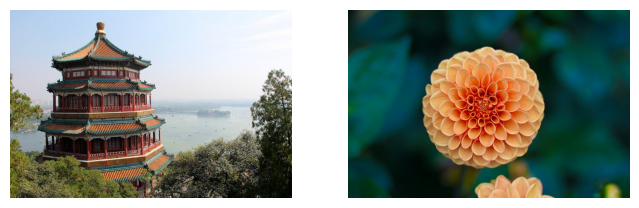

In [42]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

plt.figure(figsize=(8, 4))
for index, image in enumerate(sample_images_permuted):
    plt.subplot(1, 2, index + 1)
    plot_image(image)

In [43]:
# Let’s also use TorchVision’s CenterCrop class to center-crop the images:
#import torchvision
#import torchvision.transforms.v2 as T

cropped_images = T.CenterCrop((70, 120))(sample_images_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

This imports the TorchVision library — it’s PyTorch’s companion library for:

* image datasets (e.g., CIFAR-10, ImageNet),
* image transformations and augmentations,
* pre-trained CNN models (ResNet, VGG, etc.)  

[torchvision docs](https://docs.pytorch.org/vision/stable/index.html)

a) **T.CenterCrop((70, 120))**

Creates a transformation object that crops the center of an image (or batch of images).

The argument (70, 120) means:
* Height = 70 pixels  
* Width = 120 pixels  

So if your image is larger, the transform will keep only the central region of size 70×120 and remove borders evenly from each side.

**Cropping is common in CNN pipelines for:**

* **Standardizing input sizes**: CNNs typically require all images in a batch to be the same dimensions.

* **Focusing on central content**: The central region of an image often contains the most informative features.

* **Data preprocessing**: For example, ImageNet models often resize images to 256×256, then center-crop to 224×224 before feeding them into the network.

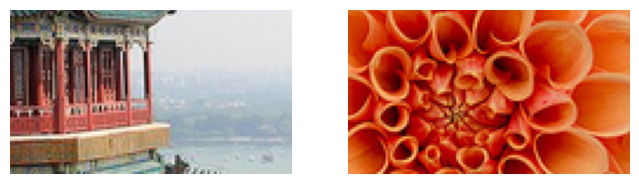

In [44]:
# demonstration of cropped images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_image(cropped_images[0])
plt.subplot(1, 2, 2)
plot_image(cropped_images[1])

Text(0.5, 0.98, 'Cropped and Original images')

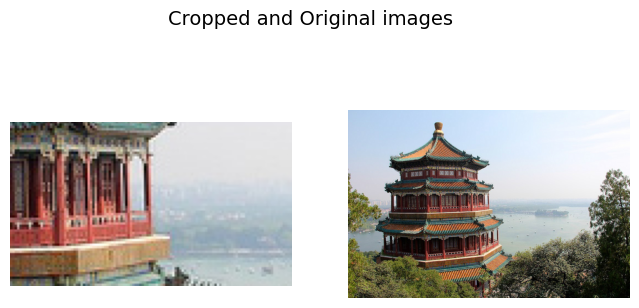

In [45]:
# demonstration of cropped images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_image(cropped_images[0])
plt.subplot(1, 2, 2)
plot_image(sample_images_permuted[0])
plt.suptitle("Cropped and Original images", fontsize=14)

## Demonstration of Convolutional Operation

Manual implementation of the convolutional operation, reproducing the effects described when applying line-detection filters (generated by Notebook LM based on the textbook chapter).

In [46]:
# --- 1. Define Input Image (Grayscale) ---
# Create a 32x32 image with a white grid pattern (simulating both H and V lines)
img_size = 32
input_image_np = np.zeros((img_size, img_size), dtype=np.float32)

# Add vertical white lines (set rows 5 and 15 to 1.0)
input_image_np[:, 10:12] = 1.0
input_image_np[:, 20:22] = 1.0

# Add horizontal white lines (set columns 5 and 15 to 1.0)
input_image_np[10:12, :] = 1.0
input_image_np[20:22, :] = 1.0

In [47]:
# PyTorch requires (Batch, Channel, Height, Width) format for input
input_tensor = torch.tensor(input_image_np).unsqueeze(0).unsqueeze(0)
# Shape: (1, 1, 32, 32) -> 1 image, 1 channel (grayscale), 32x32 size

# --- 2. Define Filters (7x7 kernels) ---
kernel_size = 7
# Kernels are stored as (Output Channels, Input Channels, H, W)

The unsqueeze(0) method is used twice to add two new dimensions to the tensor, transforming it from a 2D array to a 4D tensor, which is the expected input format for PyTorch convolutional layers.

- Initial input_image_np: After converting from NumPy to a PyTorch tensor, it has a shape of (Height, Width) (e.g., (32, 32)).  
- First unsqueeze(0): Adds a dimension of size 1 at index 0. The shape becomes (1, Height, Width) (e.g., (1, 32, 32)). This new dimension represents the Batch Size (indicating a single image in this batch).  
- Second unsqueeze(0): Adds another dimension of size 1 at index 0 again (which is now effectively the second dimension overall). The shape becomes (1, 1, Height, Width) (e.g., (1, 1, 32, 32)). This second new dimension represents the Channel dimension. Since it's a grayscale image, there's only 1 channel.

In [48]:
# 2a. Vertical Line Filter (enhances vertical lines)
# Matrix full of 0s except for central column full of 1s [2].
vertical_kernel_np = np.zeros((kernel_size, kernel_size), dtype=np.float32)
vertical_kernel_np[:, kernel_size // 2] = 1.0 # Set central column
vertical_kernel = torch.tensor(vertical_kernel_np).unsqueeze(0).unsqueeze(0)
# Shape: (1, 1, 7, 7)

# 2b. Horizontal Line Filter (enhances horizontal lines)
# Matrix full of 0s except for central row full of 1s [3].
horizontal_kernel_np = np.zeros((kernel_size, kernel_size), dtype=np.float32)
horizontal_kernel_np[kernel_size // 2, :] = 1.0 # Set central row
horizontal_kernel = torch.tensor(horizontal_kernel_np).unsqueeze(0).unsqueeze(0)
# Shape: (1, 1, 7, 7)

In [49]:
# --- 3. Perform Convolution (using "same" padding and stride 1) ---
# We use padding="same" to ensure the output size matches the input size,
# which is implied when describing the enhanced/blurred image output [1].
padding = kernel_size // 2 # For a 7x7 kernel, padding=3 gives "same" padding
stride = 1


In [50]:

# Apply Vertical Filter (to produce top-left image concept)
vertical_output = F.conv2d(
    input_tensor,
    vertical_kernel,
    padding=padding,
    stride=stride
)

# Apply Horizontal Filter (to produce upper-right image concept)
horizontal_output = F.conv2d(
    input_tensor,
    horizontal_kernel,
    padding=padding,
    stride=stride)

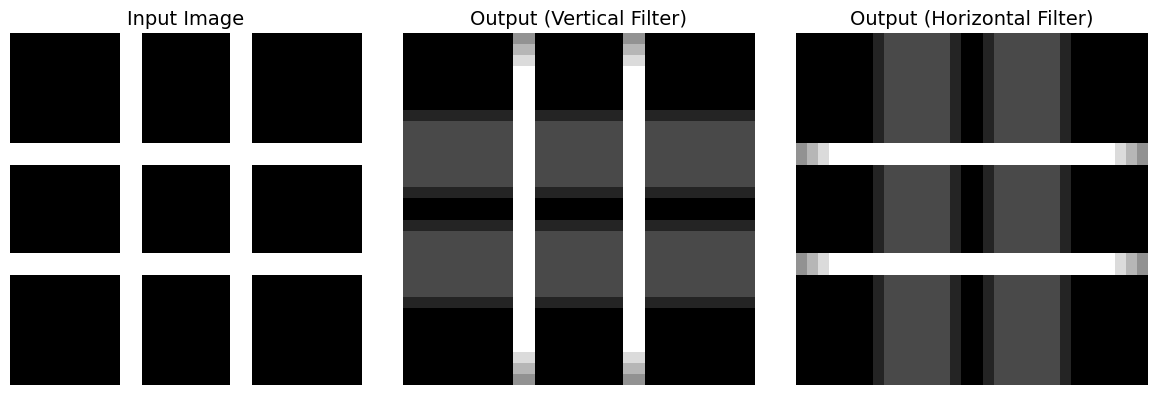

In [51]:
# --- 4. Visualize Output ---
# Extract the resulting 2D arrays for plotting
vertical_result = vertical_output.squeeze().detach().numpy()
human_readable_horizontal_kernel = horizontal_kernel_np
human_readable_vertical_kernel = vertical_kernel_np
horizontal_result = horizontal_output.squeeze().detach().numpy()
input_img = input_tensor.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Input Image
axes[0].imshow(input_img, cmap='gray')
axes[0].set_title("Input Image")

# Plot 2: Vertical Line Enhancement (Simulated Figure 12-5 Top-Left)
axes[1].imshow(vertical_result, cmap='gray')
# Vertical white lines get enhanced while the rest gets blurred [1].
axes[1].set_title(
    "Output (Vertical Filter)"
)

# Plot 3: Horizontal Line Enhancement (Simulated Figure 12-5 Upper-Right)
axes[2].imshow(horizontal_result, cmap='gray')
# Horizontal white lines get enhanced while the rest is blurred out [1].
axes[2].set_title(
    "Output (Horizontal Filter)"
)

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

* [functional.conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html)  
   - input - input tensor of shape (minibatch, in_channels, iH, iW)  
   - weight – filters of shape (out_channels, m_channels / groups in_channels(default=1),kH,kW)


In [54]:
vertical_output.shape

torch.Size([2, 1, 70, 120])

Let's reproduce and inspect the textbook example of using different filters (horizontal and vertical lines) on the same image. We re-use already created filters, but test them on the cropped images. First, we change the input channels in the filters.

In [53]:
# --- Do the textbook example ---
# Apply Vertical Filter
# Adapt vertical_kernel to have 3 input channels to match cropped_images (RGB)
vertical_kernel_for_rgb = vertical_kernel.repeat(1, cropped_images.shape[1], 1, 1)
vertical_output = F.conv2d(
    cropped_images,
    vertical_kernel_for_rgb,
    padding=padding,
    stride=stride
)

# Apply Horizontal Filter
horizontal_kernel_for_rgb = horizontal_kernel.repeat(1, cropped_images.shape[1], 1, 1)
horizontal_output = F.conv2d(
    cropped_images,
    horizontal_kernel_for_rgb,
    padding=padding,
    stride=stride)

The repeat() method duplicates the tensor along the specified dimensions. The arguments (1, 3, 1, 1) instruct PyTorch to:
- Repeat the batch dimension (first 1) once (no change).
- Repeat the channel dimension (second 3) three times. This expands the single-channel kernel into one that has identical weights across three input channels.
- Repeat the height dimension (third 1) once (no change).
- Repeat the width dimension (fourth 1) once (no change).

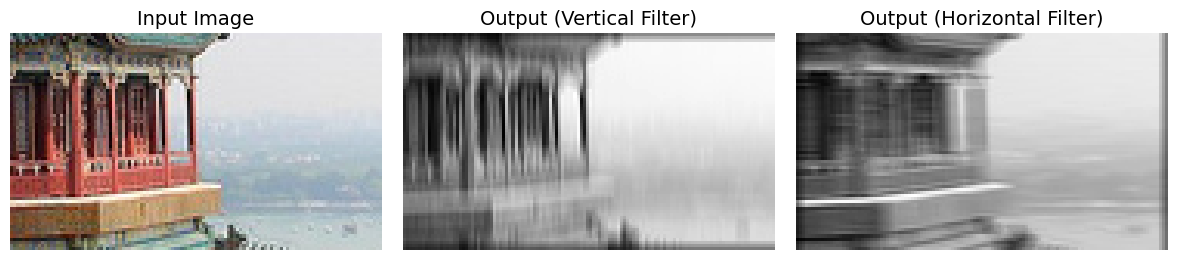

In [55]:
# Extract the resulting 2D arrays for plotting
vertical_result = vertical_output[0].squeeze().detach().numpy() # Select the first image from the batch
human_readable_horizontal_kernel = horizontal_kernel_np
human_readable_vertical_kernel = vertical_kernel_np
horizontal_result = horizontal_output[0].squeeze().detach().numpy()
input_img = cropped_images[0].squeeze().detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Input Image
# Function expects 3-channel images to have the channels as the last dimension (height, width, channels),
# but input_img has the channels as the first dimension (channels, height, width).
axes[0].imshow(input_img.transpose(1, 2, 0)) # Permute to (H, W, C) for imshow
axes[0].set_title("Input Image")

# Plot 2: Vertical Line Enhancement (Simulated Figure 12-5 Top-Left)
axes[1].imshow(vertical_result, cmap='gray')
# Vertical white lines get enhanced while the rest gets blurred [1].
axes[1].set_title(
    "Output (Vertical Filter)"
)

# Plot 3: Horizontal Line Enhancement (Simulated Figure 12-5 Upper-Right)
axes[2].imshow(horizontal_result, cmap='gray')
# Horizontal white lines get enhanced while the rest is blurred out [1].
axes[2].set_title(
    "Output (Horizontal Filter)"
)

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Now let’s create a 2D convolutional layer and feed it these cropped images to see what comes out. For this, PyTorch provides the **nn.Conv2d layer**. Under the hood, this layer relies on the torch.nn.functional.conv2d() function.

Let’s create a convolutional layer with:
* 32 filters
* each of size 7 × 7 (using kernel_size=7, which is equivalent to using kernel_size=(7 , 7))
* and apply this layer to our small batch of two images.

In [56]:

conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
fmaps = conv_layer(cropped_images)

This imports PyTorch’s neural network module, which provides building blocks like:
* nn.Conv2d — convolution layers  
  * out_channel - number of channels produced by convolution
* nn.Linear — fully connected layers
* nn.ReLU, nn.MaxPool2d, etc.

Source: [PyTorch Conv2d docs](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

These are the higher-level layer classes that automatically track parameters (weights and biases) and gradients during training.

When we talk about a 2D convolutional layer, “2D” refers to the number of spatial dimensions (height and width), but as you can see, the layer takes 4D inputs: the two additional dimensions are the batch size (first dimension) and the channels (second dimension).

In [57]:
# illustration of 4 dimensions of input
# shape without zero padding
fmaps.shape

torch.Size([2, 32, 64, 114])

There are 32 channels instead of 3 (the second position in shape results). This is because we set *out_channels=32*, so we get 32 output feature maps: instead of the intensity of red, green, and blue at each location, we now have the *intensity of each feature at each location*.

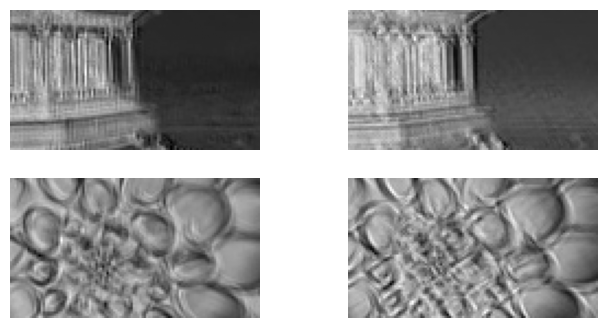

In [58]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(8, 4))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, fmap_idx].detach(), cmap="gray")
        plt.axis("off")

plt.show()

Randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [59]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7,
                        padding="same")
fmaps = conv_layer(cropped_images)

# shape with zero padding
fmaps.shape
torch.Size([2, 32, 70, 120])

torch.Size([2, 32, 70, 120])

If instead we set padding="same", then the inputs are padded with enough zeros on all sides to ensure that the output feature maps end up with the same size as the inputs

In [60]:
# the output shape when we set strides=2
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2,
                       padding=3)
fmaps = conv_layer(cropped_images)
fmaps.shape

torch.Size([2, 32, 35, 60])

If the stride is greater than 1 (in any direction), then the output size will be much smaller than the input size. For example, assuming the input size is 70 × 120, then if you set stride=2 (or equivalently stride=(2, 2)), padding=3, and kernel_size=7, then the output feature maps will be 35 × 60: halved both vertically and horizontally.  
* You could set a very large padding value to make the output size identical to the input size, but that’s almost certainly a bad idea since it would drown your image in a sea of zeros (for this reason, PyTorch raises an exception if you set padding="same" along with a stride greater than 1).

Just like a nn.Linear layer, a nn.Conv2d layer holds all the layer’s parameters, including the kernels and biases, which are accessible via the weight and bias attributes:

In [61]:
conv_layer.weight.shape

torch.Size([32, 3, 7, 7])

The weight tensor is 4D, and its shape is [output_channels, input_channels, kernel_height, kernel_width].

In [62]:

conv_layer.bias.shape

torch.Size([32])

The bias tensor is 1D, with shape [output_channels]. The number of output channels is equal to the number of output feature maps, which is also equal to the number of filters.  

Both the weight and bias parameters are initialized randomly.

the height and width of the input images do not appear in the kernel’s shape: this is because all the neurons in the output feature maps share the same weights, as explained earlier. This means that you can feed images of any size to this layer, as long as they are at least as large as the kernels, and if they have the right number of channels (three in this case).

### Role of activation function

It’s important to add an activation function after each convolutional layer. This is for the same reason as for nn.Linear layers: a convolutional layer performs a linear operation, so if you stacked multiple convolutional layers without any activation functions, they would all be equivalent to a single convolutional layer, and they wouldn’t be able to learn anything really complex.

# Pooling Layers

Pooling layer subsamples (i.e., shrinks) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).  

* Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field.

* A pooling neuron has no weights or biases; all it does is aggregate the inputs using an aggregation function such as the max or mean.


<img src = 'https://drive.google.com/uc?id=1PeybvnOHvQVeF2QyBJ2rpur1uEQM7wo_' width = 600 alt='Pooling Layer Illustration'>

Figure shows a max pooling layer, which is the most common type of pooling layer. In this example, we use a 2 × 2 pooling kernel,⁠ with a stride of 2 and no padding. Only the max input value in each receptive field makes it to the next layer, while the other inputs are dropped.
* The input values are 1, 5, 3, and 2, so only the max value, 5, is propagated to the next layer.
* Because of the stride of 2, the output image has half the height and half the width of the input image (rounded down since we use no padding).

## Implementing Pooling Layers with PyTorch

The following code creates a **nn.MaxPool2d layer**, using a 2 × 2 kernel.
* The strides default to the kernel size, so this layer uses a stride of 2 (horizontally and vertically).   
* By default, it uses padding=0 (i.e., “valid” padding):

In [ ]:
max_pool = nn.MaxPool2d(kernel_size=2)


In [ ]:
output_max = max_pool(cropped_images)

Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. This may seem surprising, since computing the mean generally loses less information than computing the max. But:
* max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with;   
* Max pooling offers stronger **translation invariance** than average pooling;
* Max pooling requires slightly less compute.

In [ ]:
avg_pool = nn.AvgPool2d(kernel_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

In [ ]:
# this cells shows what max pooling with stride = 2 looks like

fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax1.imshow(cropped_images[0].permute(1, 2, 0))
ax1.axis('off')
ax1.set_title("Original image")

ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.imshow(output_max[0].permute(1, 2, 0))
ax2.axis('off')
ax2.set_title("Max pooling")

ax3 = plt.subplot2grid((2, 3), (1, 2))
ax3.imshow(output_avg[0].permute(1, 2, 0))
ax3.axis('off')
ax3.set_title("Avg pooling")

plt.tight_layout()
plt.show()

#### Concept of invariance  

<img src = 'https://drive.google.com/uc?id=116_9AxiuGsLtAznSM7vxamcmoaszBxOv' width = 600 alt='Pooling Layer Illustration'>

a max pooling layer also introduces some level of invariance to small translations. Assume that the bright pixels have a lower value than dark pixels, and we consider three images (A, B, C) going through a max pooling layer with a 2 × 2 kernel and stride 2. Images B and C are the same as image A, but shifted by one and two pixels to the right. As you can see, the outputs of the max pooling layer for images A and B are identical. This is what translation invariance means.

Max pooling and average pooling can also be performed along the depth dimension instead of the spatial dimensions, although it’s not as common. This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern (such as handwritten digits) and the depthwise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything: thickness, brightness, skew, color, and so on.





<img src = 'https://drive.google.com/uc?id=1XLlUBHlVxBmoMN6MF126etTBcjtp_C0_' width = 600 alt='Depthwise Max Pooling Layer Illustration'>

In [ ]:
import torch.nn.functional as F

class DepthMaxPool2(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.reshape(batch, channels, height * width)  # merge spatial dims
        Z = Z.permute(0, 2, 1)  # switch spatial and channels dims
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride,
                         padding=self.padding)  # compute max pool
        Z = Z.permute(0, 2, 1)  # switch back spatial and channels dims
        return Z.reshape(batch, -1, height, width)  # unmerge spatial dims

Я пытался оценить, как выглядит картинка после обработки, но оказалось, что это не самая легкая задача. Пока пропускаю, но в идеале как-нибудь это закончить.

#### Global Average Pooling Layer

It computes the mean of each entire feature map.   
* it outputs a single number per feature map and per instance.  
  * this is extremely destructive (most of the information in the feature map is lost)  

How to create it:  
Method 1 - to use a regular **nn.AvgPool2d** layer and set its kernel size to the same size as the inputs. However, this is not very convenient since it requires knowing the exact dimensions of the inputs ahead of time.  
Method 2 - to use the **nn.AdaptiveAvgPool2d** layer, which lets you specify the desired spatial dimensions of the output: it automatically adapts the kernel size (with an equal stride) to get the desired result, adding a bit of padding if needed.

In [ ]:
global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)

In [ ]:
output = global_avg_pool(cropped_images)

# CNN Architectures

# Parameters in the context of CNN

Instead of using a convolutional layer with a 5 × 5 kernel, it is generally preferable to stack two layers with 3 × 3 kernels: it will use fewer parameters and require fewer computations, and it will usually perform better.

---
ChapGPT explanation:

| Option        | Receptive Field | Parameters (per filter, C = channels) | Result                                |
| ------------- | --------------- | ------------------------------------- | ------------------------------------- |
| One 5×5 Conv  | 5×5             | 25 × C                                | Larger, more expensive                |
| Two 3×3 Convs | 3×3 then 3×3    | 9 × C + 9 × C = 18 × C                | Smaller, cheaper, same spatial effect |


* A stack of two 3×3 kernels has an effective receptive field of 5×5, so it “sees” the same area of the image as a 5×5 kernel.
* But it uses fewer parameters (18C vs 25C) and fewer computations (FLOPs)
* It also introduces an extra nonlinearity (ReLU between the layers), which helps the network learn richer representations.
---

One exception is for the first convolutional layer: it can typically have a large kernel (e.g., 5 × 5 or 7 × 7), usually with a stride of 2 or more. This reduces the spatial dimension of the image without losing too much information, and since the input image only has three channels in general, it will not be too costly.  
* aggressively shrink the image early.

# MNIST

In [ ]:
from functools import partial

torch.manual_seed(42)  # extra code – ensure reproducibility
DefaultConv2d = partial(nn.Conv2d, kernel_size=3, padding="same")
model = nn.Sequential(
    DefaultConv2d(in_channels=1, out_channels=64, kernel_size=7), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=64, out_channels=128), nn.ReLU(),
    DefaultConv2d(in_channels=128, out_channels=128), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=128, out_channels=256), nn.ReLU(),
    DefaultConv2d(in_channels=256, out_channels=256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=128), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=128, out_features=64), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=64, out_features=10),
).to(device)

**Explanation of the code:**  
1. We use the functools.partial() function to define **DefaultConv2d**, which acts just like nn.Conv2d but with different default arguments: a small kernel size of 3, and "same" padding. This avoids having to repeat these arguments throughout the model.  


```
from functools import partial
def multiply(x, y):
    return x * y
# Normal call: multiply(2, 2)
double = partial(multiply, 2)
print(double(5))  # Output: 10
```  
* partial(...) creates a pre-configured Conv2d that by default uses 3×3 kernels and "same" padding. You can still override any argument when you call it.

2. We create the **nn.Sequential model**:
  * first layer is a DefaultConv2d with 64 fairly large filters (7 × 7).   
    * It uses the default stride of 1 because the input images are not very large.
    * It also uses in_channels=1 because the Fashion MNIST images have a single color channel (i.e., grayscale).
3. Each convolutional layer is followed by the ReLU **activation function**.  
4. Add a max **pooling layer** with a kernel size of 2, so it divides each spatial dimension by a factor of 2 (rounded down if needed).  
---
We repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times.   
* The number of repetitions is a hyperparameter you can tune.


Note that the number of filters doubles as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256). It makes sense for it to grow, since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features.   
**It is a common practice to double the number of filters after each pooling layer**: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load.

Next is the fully connected network, composed of two hidden dense layers (nn.Linear) with the ReLU activation function, plus a dense output layer. Since it’s a classification task with 10 classes, the output layer has 10 units.  

**The first nn.Linear layer has 2,304 input features: where did this number come from?**   
* MNIST images are 28 × 28 pixels, but the pooling layers shrink them to 14 × 14, then 7 × 7, and finally 3 × 3.   
* Just before the first nn.Linear layer, there are 256 feature maps, so we end up with 256 × 3 × 3 = 2,304 input features.   

Figuring out the number of features can sometimes be a bit difficult, but one trick is to set in_features to some arbitrary value (say, 999), and let training crash. The correct number of features appears in the error message: “RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2304 and 999x128)”.   

Another option is to use nn.LazyLinear instead of nn.Linear: it’s just like the nn.Linear layer, except it only creates the weights matrix the first time it gets called: it can then automatically set the number of input features to the correct value. Other layers—such as convolutional layers and batch norm layers—also have lazy variants.

In [ ]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [ ]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
n_epochs = 20
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

save_dir = "/content/drive/MyDrive/colab_ckpts"
os.makedirs(save_dir, exist_ok=True)
torch.save({"model_state": model.state_dict()}, f"{save_dir}/best_model.pt")


In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Choose where to store checkpoints
CKPT_DIR = "content/drive/02 Machine Learning/Chekpoints/2025-10 Week 02 CNNs"
import os
os.makedirs(CKPT_DIR, exist_ok=True)

LAST_CKPT = f"{CKPT_DIR}/cnn_last.pt"   # last checkpoint (model+optimizer)
BEST_CKPT = f"{CKPT_DIR}/cnn_best.pt"   # best model (model only, optional)


In [ ]:
# Train and save a checkpoint (run this when you train)

# ---- SAVE "last" checkpoint (model + optimizer + misc) ----
torch.save({
    "epoch": 20,  # or your actual last epoch variable
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}, LAST_CKPT)

print("Saved:", LAST_CKPT)

# ---- (Optional) Save "best" model if you track val accuracy in `history` ----
# This shows a safe pattern that only saves if we can compute best acc:
try:
    # assumes history like: history["valid_acc"] = [acc_ep1, acc_ep2, ...]
    best_epoch = int(torch.tensor(history["valid_metrics"]).argmax().item())
    torch.save({"model_state": model.state_dict()}, BEST_CKPT)
    print(f"Saved BEST snapshot (epoch {best_epoch}) to:", BEST_CKPT)
except Exception as e:
    print("Skipped saving BEST snapshot (no history['valid_acc']?):", e)

## AlexNet
* It was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer.  

Data Augmentation  
They performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.  

Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. This reduces overfitting, making this a regularization technique. The generated instances should be as realistic as possible: ideally, given an image from the augmented training set, a human should not be able to tell whether it was augmented or not. Simply adding white noise will not help; the modifications should be learnable (white noise is not).